#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_stock1 = pd.read_csv("../static/data/nab.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df.iloc[:-1,:]
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,29.670000,30.200001,29.650000,30.129999,30.129999,3064777.0,1.35,2.5,125.0
5747,28/07/2022,30.389999,30.490000,30.180000,30.330000,30.330000,5133887.0,1.35,2.5,125.0
5748,29/07/2022,30.480000,30.760000,30.440001,30.600000,30.600000,6165419.0,1.35,2.5,125.0
5749,1/08/2022,30.309999,30.580000,30.049999,30.580000,30.580000,5040923.0,1.35,2.5,125.0
5750,2/08/2022,30.500000,31.000000,30.370001,30.959999,30.959999,4567015.0,1.35,2.5,125.0


In [3]:
#Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

In [4]:
# # Drop all previous records now in MongoDb
# db.nab.drop()

# # Insert df records in mongodb
# records=df.to_dict('records')
# records
# db.nab.insert_many(records)

In [5]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.nab.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("DELETE: "+last_date,last_close)

db.nab.delete_one(
    {'Date': last_date}
)

DELETE: 2/08/2022 30.959999


In [6]:
#Update latest data in mongoDb
df_mongo = pd.DataFrame(list(db.nab.find()))
last_val = df_mongo.iloc[-1:].values

last_date = last_val[0][1]
last_close = last_val[0][5]
print("NEW LAST VALUE IN MONGODB: "+last_date,last_close)

NEW LAST VALUE IN MONGODB: 1/08/2022 30.58


In [7]:
from datetime import date,datetime
todaydt = date.today()
today=todaydt.strftime('%d-%m-%Y')
from_date = datetime.strptime(last_date, '%d/%m/%Y')
last_date=from_date.strftime('%d-%m-%Y')
print("Last date in MongoDb: "+last_date+". Today's date: "+today)

Last date in MongoDb: 01-08-2022. Today's date: 03-08-2022


In [8]:

#Get latest quotes from yahoo finance:
import pandas_datareader.data as web
symbol = 'NAB.AX'
start = from_date # yyyy-mm-dd
end = todaydt  # yyyy-mm-dd
stock_quote = web.DataReader(symbol,data_source='yahoo',start=start, end=end) # dataframe
stock_quote=stock_quote.iloc[1:] #skips first record
stock_quote

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2022-08-02,31.0,30.370001,30.5,30.959999,4567015,30.959999


In [9]:
tot=len(stock_quote)
rba=1.35
fed=2.5
cpi=125
a,b,c=[],[],[]
for i in range(tot):
    a.append(rba)
    b.append(fed)
    c.append(cpi)

#ADD NEW DATA IN DATAFRAME
stock_quote["RBA"],stock_quote["FED"],stock_quote["CPI"] = a,b,c
stock_quote.reset_index(inplace=True)

stock_quote['Date'] = pd.to_datetime(stock_quote['Date'])
stock_quote['Date']=stock_quote['Date'].dt.strftime('%d/%m/%Y')
stock_quote['Date']=stock_quote['Date'].astype(str)

stock_quote

,Date,High,Low,Open,Close,Volume,Adj Close,RBA,FED,CPI
0,02/08/2022,31.0,30.370001,30.5,30.959999,4567015,30.959999,1.35,2.5,125


In [10]:
records=stock_quote.to_dict('records')
print(records)

[{'Date': '02/08/2022', 'High': 31.0, 'Low': 30.3700008392334, 'Open': 30.5, 'Close': 30.959999084472656, 'Volume': 4567015, 'Adj Close': 30.959999084472656, 'RBA': 1.35, 'FED': 2.5, 'CPI': 125}]


In [11]:

db.nab.insert_many(records)
#Check if mongoDb now has latest data
df_mongo = pd.DataFrame(list(db.nab.find()))
last_vals = df_mongo.iloc[-5:].values
last_vals

array([[ObjectId('62e9aa82b214a03b317b2212'), '27/07/2022', 29.67,
        30.200001, 29.65, 30.129999, 30.129999, 3064777.0, 1.35, 2.5,
        125.0],
       [ObjectId('62e9aa82b214a03b317b2213'), '28/07/2022', 30.389999,
        30.49, 30.18, 30.33, 30.33, 5133887.0, 1.35, 2.5, 125.0],
       [ObjectId('62e9aa82b214a03b317b2214'), '29/07/2022', 30.48, 30.76,
        30.440001, 30.6, 30.6, 6165419.0, 1.35, 2.5, 125.0],
       [ObjectId('62e9aa82b214a03b317b2215'), '1/08/2022', 30.309999,
        30.58, 30.049999, 30.58, 30.58, 5040923.0, 1.35, 2.5, 125.0],
       [ObjectId('62e9aa84b214a03b317b2217'), '02/08/2022', 30.5, 31.0,
        30.3700008392334, 30.959999084472656, 30.959999084472656,
        4567015.0, 1.35, 2.5, 125.0]], dtype=object)

In [12]:
# import pandas as pd
# df_mongo = pd.DataFrame(list(db.nab.find()))
last_val_1 = df_mongo.iloc[-1:].values
last_date = last_val_1[-1][1]
last_close = last_val_1[-1][5]
print(last_close,last_date)

30.959999084472656 02/08/2022


# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [13]:
df_mongo = pd.DataFrame(list(db.nab.find()))
# Drop the null columns where all values are null
df_mongo = df_mongo.dropna(axis='columns', how='all')
# Drop the null rows
df_mongo = df_mongo.dropna()
# df_mongo["Close"]=df_mongo["Close"].astype(float)
len_df_mongo=len(df_mongo)
data = df_mongo.filter(["Close"])
dataset=data.values
dataset

array([[22.164883  ],
       [21.403856  ],
       [20.975779  ],
       ...,
       [30.6       ],
       [30.58      ],
       [30.95999908]])

In [14]:
# data = df.filter(['Close'])
# dataset = data.values
# dataset.shape

In [15]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4575, 1)

In [16]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.28791442, 0.26146737, 0.24659094, 0.23502037, 0.24130154,
       0.25154974, 0.23832627, 0.23270628, 0.22609451, 0.2418305 ,
       0.2783273 , 0.28956731, 0.27634378, 0.26232689, 0.24692153,
       0.26807911, 0.25419445, 0.25419445, 0.23802872, 0.2502274 ,
       0.23935106, 0.23766508, 0.24394619, 0.23164837, 0.23601218,
       0.24163217, 0.23832627, 0.24229329, 0.23964864, 0.23402862,
       0.2217969 , 0.2211688 , 0.2049369 , 0.19663915, 0.19204396,
       0.18708515, 0.17981223, 0.17551465, 0.17848986, 0.20496995,
       0.20526749, 0.22510273, 0.24844223, 0.25396308, 0.22649124,
       0.21022626, 0.22311917, 0.20625924, 0.18146513, 0.19138277,
       0.18410988, 0.19733342, 0.20526749, 0.21518516, 0.20625924,
       0.20715184, 0.21981334, 0.23733445, 0.23832627, 0.24179742])]
[0.22344979789408392]


# Prepare train data for LSTM model

In [17]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4515, 60)

In [18]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4515, 60, 1)

# Build the LSTM model

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [20]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4515/4515 [==============================] - 66s 14ms/step - loss: 0.0011


In [22]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [23]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [24]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [25]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.10663655411121704

C:\Users\antoi\AppData\Local\Temp/ipykernel_4696/1559395553.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


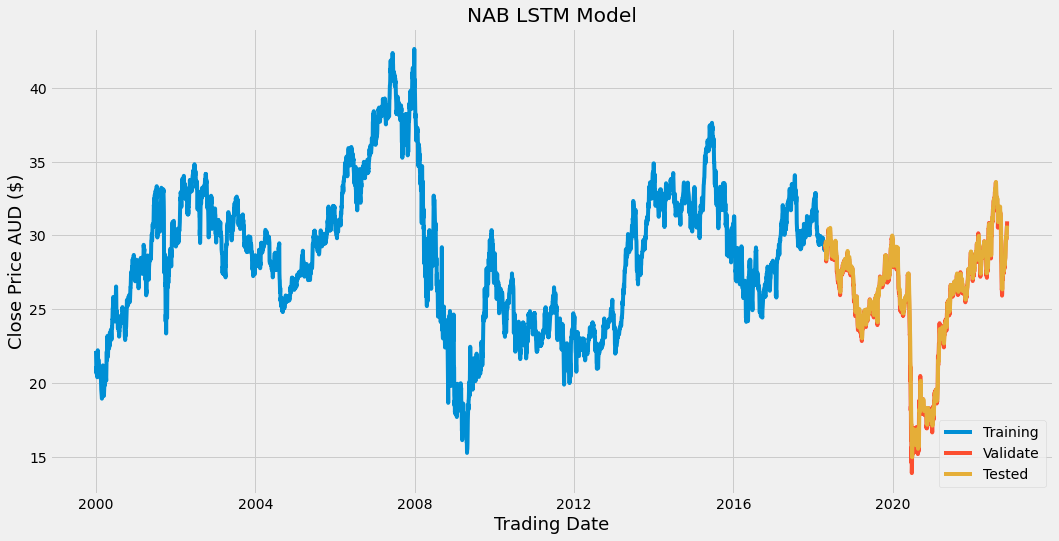

In [26]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('NAB LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training','Validate','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nab_graph.png')
plt.show()


# Test data Predictions on the Model

In [27]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_4696/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4575,29.260000,29.267813,-0.007813
4576,29.070000,29.340574,-0.270574
4577,29.129999,29.264427,-0.134428
4578,29.299999,29.248741,0.051258
4579,29.559999,29.358267,0.201732
...,...,...,...
5713,30.129999,29.816587,0.313412
5714,30.330000,30.021757,0.308243
5715,30.600000,30.282070,0.317930
5716,30.580000,30.572578,0.007422


In [28]:
# Use last 60 days price on model to predict next days price
import pandas as pd

df_mongo = pd.DataFrame(list(db.nab.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty.shape

(60, 1)

In [29]:
last_60_days_scaled = scaler.transform(last_sixty)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [30]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = round(float(pred_price),2)
print(f'{last_date} Last close ${last_close} Predicted next day share price ${pred_price}')

02/08/2022 Last close $30.959999084472656 Predicted next day share price $30.35


# Save the Model

In [31]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/nab_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list nab_sixty and load df

#PREDICT USING LOADED MODEL

In [32]:
from keras.models import load_model
model_in = load_model('../static/nab_model.sav')

In [33]:

# query the nab collection and load into dataframe
import pandas as pd

df_mongo = pd.DataFrame(list(db.nab.find()))
sixty_val = df_mongo.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

last_sixty

array([[31.110001  ],
       [30.24      ],
       [30.379999  ],
       [30.65      ],
       [31.17      ],
       [31.110001  ],
       [31.129999  ],
       [30.700001  ],
       [30.75      ],
       [30.735001  ],
       [30.950001  ],
       [31.290001  ],
       [31.49      ],
       [31.540001  ],
       [31.51      ],
       [31.26      ],
       [31.42      ],
       [31.110001  ],
       [31.120001  ],
       [30.805     ],
       [30.059999  ],
       [28.84      ],
       [27.879999  ],
       [28.045     ],
       [26.4       ],
       [26.309999  ],
       [26.219999  ],
       [25.43      ],
       [25.950001  ],
       [26.42      ],
       [26.809999  ],
       [27.09      ],
       [26.870001  ],
       [27.540001  ],
       [27.559999  ],
       [27.67      ],
       [27.389999  ],
       [27.51      ],
       [27.690001  ],
       [27.469999  ],
       [27.75      ],
       [27.85      ],
       [28.01      ],
       [27.66      ],
       [27.950001  ],
       [28

In [34]:
from keras.models import load_model
model_in = load_model('../static/nab_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

price_list=[]

#Function to predict future days predicted price, in loop
input = 180 #days
if input == "":
    input = 180
else:
   input = int(input)

def predict_nab(last_sixty,model_in,input):
    for i in range(1, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    # print(price_list)
    return price_list

price_pred = predict_nab(last_sixty,model_in,input)
price_pred

1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day finished! Price: 
41
Day fi

[30.27,
 30.26,
 30.24,
 30.22,
 30.2,
 30.2,
 30.21,
 30.22,
 30.24,
 30.27,
 30.3,
 30.34,
 30.37,
 30.4,
 30.43,
 30.47,
 30.49,
 30.52,
 30.55,
 30.57,
 30.6,
 30.62,
 30.64,
 30.66,
 30.69,
 30.71,
 30.74,
 30.76,
 30.78,
 30.8,
 30.82,
 30.84,
 30.86,
 30.87,
 30.88,
 30.9,
 30.91,
 30.93,
 30.94,
 30.96,
 30.97,
 30.99,
 31.01,
 31.02,
 31.04,
 31.05,
 31.07,
 31.08,
 31.1,
 31.1,
 31.11,
 31.11,
 31.12,
 31.12,
 31.12,
 31.13,
 31.13,
 31.14,
 31.14,
 31.14,
 31.15,
 31.15,
 31.16,
 31.16,
 31.16,
 31.17,
 31.17,
 31.18,
 31.18,
 31.19,
 31.19,
 31.2,
 31.2,
 31.2,
 31.21,
 31.21,
 31.21,
 31.22,
 31.22,
 31.22,
 31.22,
 31.23,
 31.23,
 31.23,
 31.23,
 31.24,
 31.24,
 31.24,
 31.24,
 31.24,
 31.25,
 31.25,
 31.25,
 31.25,
 31.25,
 31.25,
 31.26,
 31.26,
 31.26,
 31.26,
 31.26,
 31.26,
 31.26,
 31.26,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.27,
 31.28,
 31.28,
 31.28,
 31.28,
 31.28,
 31.28,
 31.28,
 31.

In [35]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,11/07/2022,Monday
1,2,12/07/2022,Tuesday
2,3,13/07/2022,Wednesday
3,4,14/07/2022,Thursday
4,5,15/07/2022,Friday
...,...,...,...
260,261,10/07/2023,Monday
261,262,11/07/2023,Tuesday
262,263,12/07/2023,Wednesday
263,264,13/07/2023,Thursday


C:\Users\antoi\AppData\Local\Temp/ipykernel_4696/2637301028.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


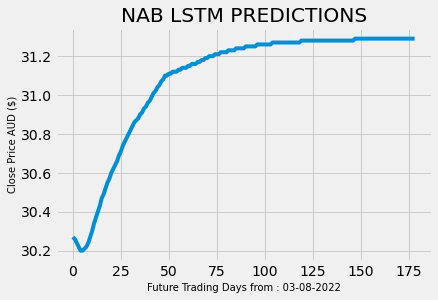

In [36]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input-1]
dates_df_iloc['Price'] = price_list
plt.plot(dates_df_iloc['Price'])
plt.title('NAB LSTM PREDICTIONS')
plt.xlabel('Future Trading Days from : '+today, fontsize=10)
plt.ylabel('Close Price AUD ($)',fontsize=10)
plt.savefig('../static/data/images/pred/nab_pred.png', bbox_inches="tight")
plt.show()


In [37]:
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 30.27},
 {'Price': 30.26},
 {'Price': 30.24},
 {'Price': 30.22},
 {'Price': 30.2},
 {'Price': 30.2},
 {'Price': 30.21},
 {'Price': 30.22},
 {'Price': 30.24},
 {'Price': 30.27},
 {'Price': 30.3},
 {'Price': 30.34},
 {'Price': 30.37},
 {'Price': 30.4},
 {'Price': 30.43},
 {'Price': 30.47},
 {'Price': 30.49},
 {'Price': 30.52},
 {'Price': 30.55},
 {'Price': 30.57},
 {'Price': 30.6},
 {'Price': 30.62},
 {'Price': 30.64},
 {'Price': 30.66},
 {'Price': 30.69},
 {'Price': 30.71},
 {'Price': 30.74},
 {'Price': 30.76},
 {'Price': 30.78},
 {'Price': 30.8},
 {'Price': 30.82},
 {'Price': 30.84},
 {'Price': 30.86},
 {'Price': 30.87},
 {'Price': 30.88},
 {'Price': 30.9},
 {'Price': 30.91},
 {'Price': 30.93},
 {'Price': 30.94},
 {'Price': 30.96},
 {'Price': 30.97},
 {'Price': 30.99},
 {'Price': 31.01},
 {'Price': 31.02},
 {'Price': 31.04},
 {'Price': 31.05},
 {'Price': 31.07},
 {'Price': 31.08},
 {'Price': 31.1},
 {'Price': 31.1},
 {'Price': 31.11},
 {'Price': 31.11},
 {'Price': 31.12},
 {

In [38]:
# len_df_mongo = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,len_df_mongo,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4575 5718 5898


,Close
5887,31.29
5888,31.29
5889,31.29
5890,31.29
5891,31.29
5892,31.29
5893,31.29
5894,31.29
5895,31.29
5896,31.29


C:\Users\antoi\AppData\Local\Temp/ipykernel_4696/3198281189.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


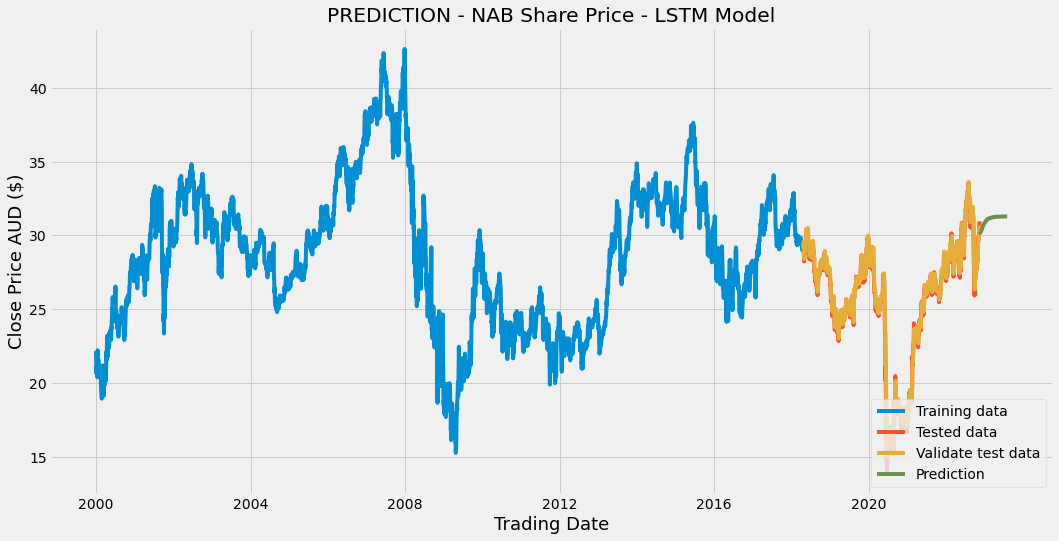

In [39]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:len_df_mongo] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[len_df_mongo:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION - NAB Share Price - LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/nab_predict_graph.png')
plt.show()

#Save predicted error to MongoDB

In [40]:
# Query all
name = 'NAB'
companys = db.companys.find({'name': name})
# Iterate through each company in the collection
for company in companys:
    print(company)


{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e8ddca939e19158042c2d3'), 'model': 'LSTM', 'name': 'NAB', 'date': '02/08/2022', 'predicted': 30.06, 'actual': 30.96, 'difference': -0.9, 'rmse': 0.22289}


In [41]:
# Delete a document from a collection
db.companys.delete_one(
    {'model': 'LSTM','name': name}
)

# query the companys collection
companys = db.companys.find({'name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}


In [42]:
# Set keys and values of company
last_close=round(float(last_close),2)
difference = pred_price-last_close
print(f'date {last_close},predicted ${pred_price}, actual ${last_close}, difference {difference}, rmse {round(rmse,5)}')

date 30.96,predicted $30.35, actual $30.96, difference -0.6099999999999994, rmse 0.10664


In [43]:
# Insert a document into the 'companys' collection
db.companys.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': last_date,
      'predicted': pred_price,
      'actual': last_close,
      'difference': round(difference,4),
      'rmse': round(rmse,5)        
    }
)

# query the classroom collection
companys = db.companys.find({'name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e9aad5b214a03b317b2218'), 'model': 'LSTM', 'name': 'NAB', 'date': '02/08/2022', 'predicted': 30.35, 'actual': 30.96, 'difference': -0.61, 'rmse': 0.10664}


In [44]:
# query all companys collection
companys = db.companys.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62cfb5f0a3e49b5607e1001b'), 'model': 'RFR', 'name': 'nhc', 'date': '14/07/2022', 'predicted': 3, 'actual': 4, 'differece': -0.4134955929131614, 'accuracy': 95.31}
{'_id': ObjectId('62df8ae0427af058c4334ede'), 'model': 'RFR', 'name': 'CBA', 'date': '26/07/2022', 'predicted': 97, 'actual': 96, 'differece': 1.0204273335669143, 'accuracy': 97.43}
{'_id': ObjectId('62dfa392f178c5283b8b5648'), 'model': 'RFR', 'name': 'MIN', 'date': '22/07/2022', 'predicted': 38, 'actual': 46, 'differece': -7.74920083942115, 'accuracy': 93.63}
{'_id': ObjectId('62dfa4d3643d249dfcfea5f3'), 'model': 'RFR', 'name': 'NAB', 'date': '26/07/2022', 'predicted': 28, 'actual': 29, 'differece': -0.9521357946721061, 'accuracy': 97.23}
{'_id': ObjectId('62e223a5553c4e8d8e53f30a'), 'model': 'LSTM', 'name': 'NHC', 'date': '28/07/2022', 'predicted': 4, 'actual': 4.4, 'differece': -0.15000000000000036, 'rmse': 0.04529}
{'_id': ObjectId('62e230eafd3e48eabe9b8365'), 'model': 'RFR', 'name': 'WBC', 'date': '28/0